# Point Net Homework

The following homework is based on the paper, "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Qi et al.

In this paper, the authors present a novel neural network architecture that takes in point clouds as inputs. This network can be used across many tasks including object segmentation, part segmentation, and scene semantic parsing. 

## 1. 3D Data Representation

There are various ways one could represent 3D before inputting into a neural network. Histocially, networks have used convolutional architecures, which require inputs to be highly standardized. As such, researchers will often convert their data into 3D voxel grids or collections of images. 

As stated by the authors, these data formats are volumous, due to data redundancy, and may introduce quantization artifacts. As such, we will be focusing on 3D Meshes and Point Clouds.



In [5]:
!pip install pyvista
!pip install numpy
!pip install pandas
!pip install torch
!pip install tqdm
!pip install trame
!pip install pytorch_model_summary
!pip install matplotlib==3.5.0
!pip install pyntcloud

import sys
sys.path
sys.path.append('./pretrained')
from test_semseg import main as pretrained_sem
%load_ext autoreload
%autoreload 2

You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
  Using cached pyntcloud-0.3.1-py2.py3-none-any.whl (346 kB)
You should consider upgrading via the '/Users/romitbarua/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pyvista as pv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pytorch_model_summary import summary
import os
import pandas as pd
from torch.utils.data import Dataset
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt

In [6]:
teapot_file_path = '../cs182-proj/images/canvas3D-master/teapot.ply'
points_data = pv.read(teapot_file_path)

### 3D Mesh

The 3D Mesh is generated using a set of polygons to represent the structure of the object. It is determined using points with X, Y, Z coordinates. These points are connected to make polygons, most commonly triangles and quads.


/Users/kylepedersen/opt/anaconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  warnings.warn(


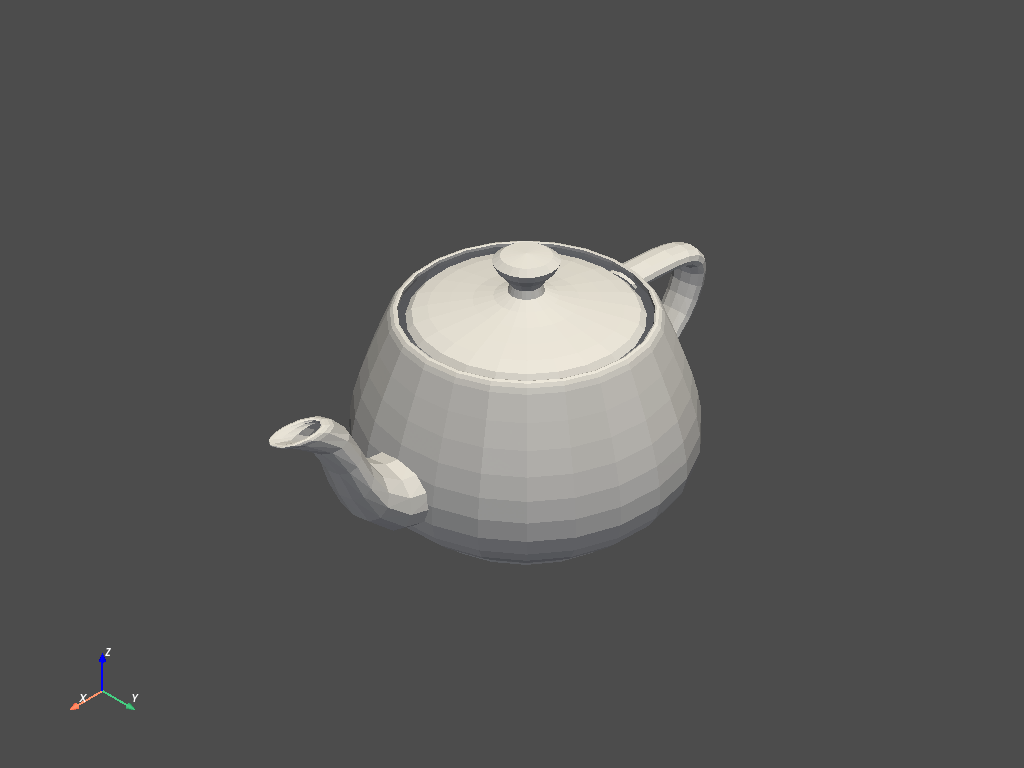

In [7]:
points_data.plot(jupyter_backend='panel')

### Point Cloud
Point Clouds are a basic data format in which the points are represented in 3D space, using X, Y, and Z coordinates.

/Users/kylepedersen/opt/anaconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  warnings.warn(


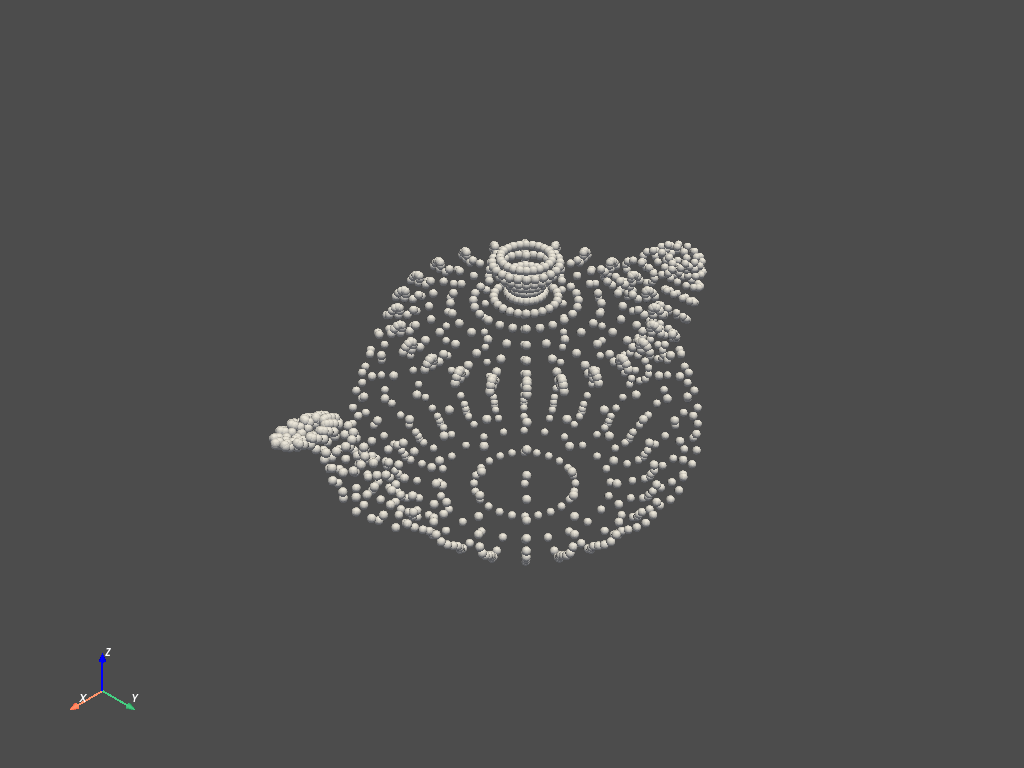

In [8]:
sphere = pv.Sphere(radius=0.05)
pc = points_data.glyph(scale=False, geom=sphere, orient=False)
pc.plot(cmap='Reds', jupyter_backend='panel')

The authors in the paper chose to use Point Clouds instead of a 3D Mesh. **Looking at the objects, why would they choose to do so?**

Solution: 3D Meshes have additional complexity and combinations that must be carried through, thereby drastically increasing the complexity of the data format. Further, there is likely little value add by including this additional information outside of for visualization purposes.

## 2. The Model Architecture

The archicture of PointNet is as follows:
![plot](images/model.png)

In the paper, the authors used the ModelNet10 dataset and the ModelNet40 dataset. The ModelNet10 dataset has 10 classes of varying objects.

![plot](images/class_detail.png)

However, given the size of the dataset, it is not feasible to train the entire model in the context of this homework. As such, we have modified the dataset to be a binary classification problem: bathtub or table.

In the following sections we will implement pieces of the architecture and see how they impact the downstream performance of the model

In [7]:
class ShapeNetDataset(Dataset):
    def __init__(self, root, train=True, n=10000):
        classes = [c for c in os.listdir(root) 
                   if os.path.isdir(os.path.join(root, c))]
        self.classes = {k: c for k, c in enumerate(classes)}
        self.path = root
        self.train = train
        self.n = n
        self.df = pd.DataFrame()
        for label, c in self.classes.items():
            path = None
            if self.train:
                path = os.path.join(self.path, c, "train")
            else:
                path = os.path.join(self.path, c, "test")
            dir_list = [dir for dir in os.listdir(path) if dir.endswith('.off')]
            label_list = [label]*len(dir_list)
            df = pd.DataFrame(list(zip(dir_list, label_list)), columns=['path', 'label'])
            self.df = pd.concat((self.df, df))
        self.df.reset_index(inplace=True, drop=True)

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        '''
        Returns (3 X N, label)
        '''
        path, label = self.df.loc[idx, 'path'], self.df.loc[idx, 'label']
        get_file = lambda p, t: PyntCloud.from_file(os.path.join(self.path, self.classes[label], t, p))
        test_train = 'train' if self.train else 'test'
        pointcloud = get_file(path, test_train).get_sample('mesh_random', n=self.n)
        return torch.Tensor(pointcloud.values).transpose(0,1), label  

class Logger():
    def __init__(self):
        self._log = {'train loss': [], 
                     'valid loss': [], 
                     'train accuracy': [], 
                     'valid accuracy': []}
    
    def log(self, name: str, value):
        if name not in self._log.keys():
            raise NotImplementedError
        self._log[name].append(value)

    def plot_loss(self):
        train_loss, valid_loss = self._log['train loss'], self._log['valid loss']
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Iterations vs Loss')
        fig.supxlabel('Iterations')
        fig.supylabel('Loss')
        ax1.plot(range(len(train_loss)), train_loss, label='training')
        ax1.set_title('Training')
        ax2.plot(range(len(valid_loss)), valid_loss, label='validation')
        ax2.set_title('Validation')

    def plot_accuracy(self):
        train_acc, valid_acc = self._log['train accuracy'], self._log['valid accuracy']
        plt.plot(range(len(train_acc)), train_acc, label='training')
        plt.plot(range(len(valid_acc)), valid_acc, label='validation')
        plt.title('Epochs vs Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    
def BatchPyntCloudToTensor(pyntcloud):
    # B x PyntCloud(N X 3) -> B x 3 X N 
    pointcloud = pyntcloud.points.values
    return torch.Tensor(pointcloud).transpose(1, 2)


# class S3DISDataset(Dataset): /datautils
#     # you can download dataset through this google form http://buildingparser.stanford.edu/dataset.html
# and here we might use the dataloader with reference from https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/data_utils/S3DISDataLoader.py
# /datautils need to be modified.

In [8]:
def loss_fn(preds, labels, feature_transform, reg=0.0001):
    #loss = torch.nn.NLLLoss()
    target_ar = np.zeros(preds.shape)
    for i in range(target_ar.shape[0]):
        label_idx = labels[i]
        target_ar[i, label_idx] = 1
        
    loss = torch.nn.BCELoss()
    #loss = torch.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
    def feat_loss(A):
        I = torch.eye(64, requires_grad=True).expand(A.size(0), -1, -1)
        AA_T = torch.bmm(A, A.transpose(1, 2))
        return torch.linalg.norm(I - AA_T, ord='fro', dim=(1,2))
    #return loss(torch.softmax(preds, dim=1), labels) + reg * torch.mean(feat_loss(feature_transform))
    #return loss + reg * torch.mean(feat_loss(feature_transform))
    return loss(torch.softmax(preds, dim=1), torch.tensor(target_ar).float()) + reg * torch.mean(feat_loss(feature_transform))

def train(model, trainset, validset, optimizer, epochs=10, batch_size=32, logger=None):
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

    model = model.to(device)

    train_loss, valid_loss = 0.0, 0.0
    for _ in range(epochs):
        model.train()
        # Train and get training loss and accuracy
        train_num_correct = 0
        train_count = 0
        for x, y in tqdm(train_dataloader, unit='batch'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred, feat = model(x)
            #print(pred)
            #print(y)
            loss = loss_fn(pred, y, feat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print(torch.sum(pred.argmax(1) == y).item())
            train_num_correct += torch.sum(pred.argmax(1) == y).item()
            train_count += y.shape[0]
            logger.log('train loss', train_loss)
            
            train_loss = 0
        
        logger.log('train accuracy', train_num_correct / train_count)

        model.eval()
        # Get validation loss and accuracy
        with torch.no_grad():
            valid_num_correct = 0
            valid_count = 0 
            for x, y in tqdm(valid_dataloader, unit='batch'):
                x, y = x.to(device), y.to(device)
                pred, feat = model(x)
                loss = loss_fn(pred, y, feat)
                valid_loss += loss.item()
                #print(pred.argmax(1))
                #print(y)
                valid_num_correct += torch.sum(pred.argmax(1) == y).item()
                valid_count += y.shape[0]
                logger.log('valid loss', valid_loss)
                
                valid_loss = 0
                
        logger.log('valid accuracy', valid_num_correct / valid_count)


In [9]:
n = 10000
num_classes = 2
epochs = 2
lr = 0.0001
device = 'cpu'

trainset = ShapeNetDataset("datasets/ModelNet2", train=True, n=n)
testset = ShapeNetDataset("datasets/ModelNet2", train=False, n=n)

dataset_length = len(trainset)
train_ratio = 0.7
test_ratio = 0.3

train_len = int(dataset_length * train_ratio)
valid_len = dataset_length - train_len

trainset, validset = random_split(trainset, [train_len, valid_len])


### 2.1 Baseline Architecture

The first draft of the model will exclude the input transform and the feature transform.

Baseline Architecture:
![plot](images/baseline_network.png)

In the following section, please implement the following:
- Complete the SharedMLP Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Complete the forward function for the BaselineClassificationNN




In [10]:
class MLP(nn.Sequential):
    def __init__(self, layer_sizes, dropout=0.7):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        super(MLP, self).__init__(*layers)
            

class SharedMLP(nn.Sequential):
    def __init__(self, layer_sizes):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Conv1d(layer_sizes[i], layer_sizes[i+1], 1))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.ReLU())
        super(SharedMLP, self).__init__(*layers)

In [11]:
class BaselineClassificationNN(nn.Module):
    def __init__(self, num_classes, pool_type='max'):
        super(BaselineClassificationNN, self).__init__()
        
        ##################################################
        # TO DO:
        # Update the dimensions for the MLP layers below using the architecture
        ##################################################
        #self.shared_mlp_1 = SharedMLP([...])
        #self.shared_mlp_2 = SharedMLP([...])
        #self.mlp = MLP([...])
        
        self.pool_type = pool_type
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])
        
        ##################################################

    def forward(self, x):
        
        ##################################################
        # TO DO:
        # Create the forward function
        # For the baseline model, please follow the architecture diagram for the
        # Here, we will skip the Input Transform and the Feature Transform
        # Notice that we have a pool_type parameter which can be either "max" or "avg"
        # Please include an if statement accordingly
        
        #Note that the feat_out will be part of the regularizer.
        #In the original architecture, the feat_out will be the output of the feature transform
        #Howver, here since we have not yet implemented the feature transform, please set feat_out
        #to be the output of of the first MLP
        
        ##################################################

        feat_out = self.shared_mlp_1(x)
        out = self.shared_mlp_2(feat_out)
        if self.pool_type == 'max':
            out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        elif self.pool_type == 'avg':
            out = F.avg_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)

        ##################################################
        
        return out, feat_out
    
        

    def predict(self, x):
        return self.forward(x)[0]

**Baseline Test Case:**

Before training the baseline model, run the following test case to make sure your implementation is correct with respect to tensor dimensions.

In [12]:
def testBaselineClassificationNN():
    torch.manual_seed(42)
    np.random.seed(42)
    
    batch_size = 5
    input_channels = 3
    input_length = 20
    num_classes = 10
    
    x = torch.arange(1, 301, 1).view(batch_size, input_channels, input_length).float()
    model = BaselineClassificationNN(num_classes)
    output, features_out = model.forward(x)

    expected_output = torch.tensor([
    [0.0000, 0.0000, -0.0000, 5.2441, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000],
    [0.7500, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000],
    [0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000],
    [0.0000, -0.0000, 0.6712, 0.0000, -0.0000, 0.0000, -0.0000, 1.7654, -0.0000, 0.0000],
    [0.6772, 4.4127, 0.0000, 0.0000, 0.0000, 3.8785, 0.0000, 0.0000, 0.0000, -0.0000]
    ], dtype=torch.float32)


    assert torch.all(torch.isclose(output, expected_output, atol=1e-3)), "Output tensor values not close to expected value."
    assert output.size() == (batch_size, num_classes), "Output tensor has incorrect dimensions."
    assert features_out.size() == (batch_size, 64, input_length), "Feature tensor has incorrect dimensions."
    print("Test passed!")

testBaselineClassificationNN()

Test passed!


**Train the Avg Pool Baseline Model**

In [13]:
baseline_model = BaselineClassificationNN(num_classes, pool_type='avg')
logger = Logger()

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
train(baseline_model, trainset, validset, optimizer, epochs=epochs, logger=logger)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

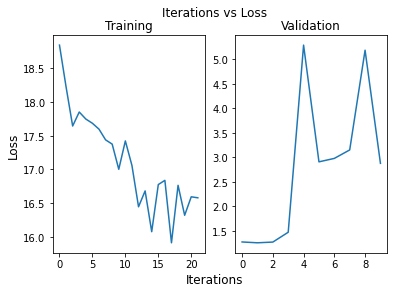

In [14]:
logger.plot_loss()

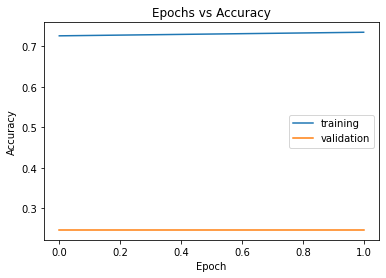

In [15]:
logger.plot_accuracy()

**Train Model with Max Pooling**

In [16]:
baseline_model = BaselineClassificationNN(num_classes, pool_type='max')
logger = Logger()

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
train(baseline_model, trainset, validset, optimizer, epochs=epochs, logger=logger)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

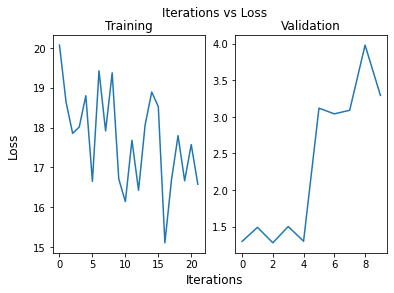

In [17]:
logger.plot_loss()

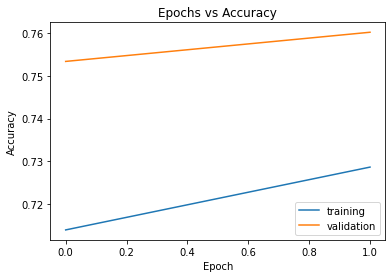

In [18]:
logger.plot_accuracy()

### 2.2 Add Input Transform

In the following section, please implement the following:

Input Transform Architecture:
![plot](images/add_input_transform.png)

- Complete the TNet Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Modify the BaselineClassificationNN to include the Input Transform

In [20]:
class T_net(nn.Module):
    def __init__(self, size, dropout=0.7, bn_momentum=None):
        super(T_net, self).__init__()
        self.size = size

        self.shared_mlp = SharedMLP([size, 64, 128, 1024])

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, size*size, bias=False)
        self.fc3.requires_grad_(False)

        self.bn1 = nn.BatchNorm1d(512, momentum=bn_momentum)
        self.bn2 = nn.BatchNorm1d(256, momentum=bn_momentum)

    def forward(self, x):
        '''
            Input: B x size x N
        '''
        out = self.shared_mlp(x)
        out = F.max_pool1d(out, kernel_size=x.size(-1))
        out = out.view(-1, 1024)
        out = F.relu(self.bn1(self.fc1(out)))
        out = F.relu(self.bn2(self.fc2(out)))

        out = self.fc3(out)
        out = out.view(-1, self.size, self.size)
        bias = torch.eye(self.size, requires_grad=True).expand(x.size(0), -1, -1)
        return out + bias


In [21]:
class InputTransform(nn.Module):
    def __init__(self):
        super(InputTransform, self).__init__()
        self.T_net = T_net(3)

    def forward(self, x):
        
        ##################################################
        # TO DO:
        # Create the forward function
        # In this function, we will run the input through the model
        # then element-wise multiply the original input with the output
        # torch.bmm could be useful here
        # You may also need to transpose the data
        ##################################################
        
        out = self.T_net(x)
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)
    
        ##################################################

In [22]:
class InputTransformClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(InputTransformClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):
        
        ##################################################
        # TO DO:
        # Create the forward function
        # You can copy and paste the code from the baseline class above and add the Input Transform
        # again here, the feat_out will be the ouput of the first MLP
        ##################################################

        out = self.input_transform(x)
        feat_out = self.shared_mlp_1(out)
        out = self.shared_mlp_2(feat_out)
        out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)
        
        ##################################################
        
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

**Input Transform Test Case**

Before training the baseline model with the input transform added, run the following test case to make sure your implementation is correct with respect to tensor dimensions.

In [23]:
def testInputTransformClassificationNN():
    torch.manual_seed(42)
    np.random.seed(42)
    
    batch_size = 5
    input_channels = 3
    input_length = 20
    num_classes = 10
    
    x = torch.arange(1, 301, 1).view(batch_size, input_channels, input_length).float()
    model = InputTransformClassificationNN(num_classes)
    output, features_out = model.forward(x)
    
    expected_output = torch.tensor([[0.0000, 0.0000, 3.8678, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
     0.0000],
    [0.0000, -0.0000, 1.2132, 0.0000, 2.7523, 4.5780, 0.0000, 0.0000, -0.0000,
     0.0000],
    [-0.0000, 5.2818, 0.0000, 0.0000, 0.0000, 0.2553, 0.0000, -0.0000, 0.0000,
     0.0000],
    [-0.0000, -0.0000, -0.0000, 0.9948, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
     -0.0000],
    [4.2480, 2.4292, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
     -0.0000]], dtype=torch.float32)


    assert torch.all(torch.isclose(output, expected_output, atol=1e-3)), "Output tensor values not close to expected value."
    assert output.size() == (batch_size, num_classes), "Output tensor has incorrect dimensions."
    assert features_out.size() == (batch_size, 64, input_length), "Feature tensor has incorrect dimensions."
    print("Test passed!")

testInputTransformClassificationNN()

Test passed!


**Train the Input Transform Classification Network**

In [24]:
input_transform_model = InputTransformClassificationNN(num_classes)
logger = Logger()

optimizer = torch.optim.Adam(input_transform_model.parameters(), lr=lr)
train(input_transform_model, trainset, validset, optimizer, epochs=epochs, logger=logger)

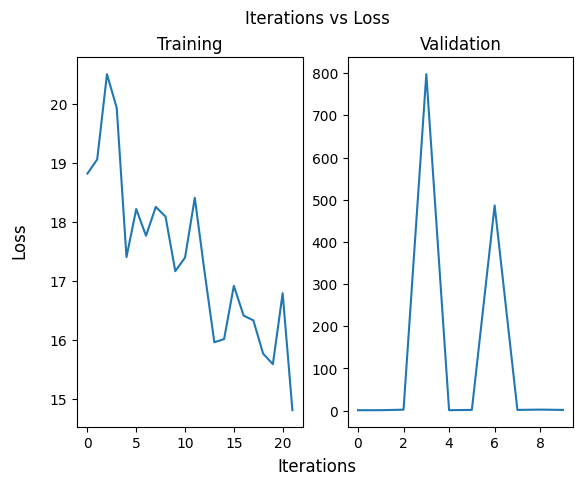

In [25]:
logger.plot_loss()

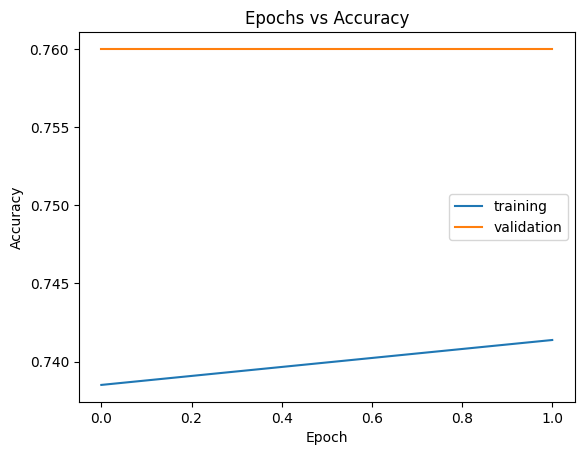

In [26]:
logger.plot_accuracy()

### 2.2 Add Feature Transform

In the following section, please implement the following:
- Complete the FeatureTransform Class
- Update the FeatureTransformClassificationNN to include the Feature Transform

Full Classification Architecture:
![plot](images/full_classification.png)

In [56]:
class FeatureTransform(nn.Module):
    def __init__(self):
        super(FeatureTransform, self).__init__()
        self.T_net = T_net(64)

    def forward(self, x):
        out = self.T_net(x)
        self.A = out
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)

In [57]:
class FullClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(FullClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):
        out = self.input_transform(x)
        out = self.shared_mlp_1(out)
        feat_out = self.feature_transform(out)
        out = self.shared_mlp_2(feat_out)
        out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

**Full Classification Network Test Case**

Before training the full network model, run the following test case to make sure your implementation is correct with respect to tensor dimensions.

In [29]:
def testFullClassificationNN():
    torch.manual_seed(42)
    np.random.seed(42)
    
    batch_size = 5
    input_channels = 3
    input_length = 20
    num_classes = 10
    
    x = torch.arange(1, 301, 1).view(batch_size, input_channels, input_length).float()
    model = InputTransformClassificationNN(num_classes)
    output, features_out = model.forward(x)

    expected_output = torch.tensor([[0.0000, 0.0000, 3.8678, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000], [0.0000, -0.0000, 1.2132, 0.0000, 2.7523, 4.5780, 0.0000, 0.0000, -0.0000,
         0.0000], [-0.0000, 5.2818, 0.0000, 0.0000, 0.0000, 0.2553, 0.0000, -0.0000, 0.0000,
         0.0000],[-0.0000, -0.0000, -0.0000, 0.9948, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         -0.0000],[4.2480, 2.4292, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
         -0.0000]], dtype=torch.float32)

    assert torch.all(torch.isclose(output, expected_output, atol=1e-3)), "Output tensor values not close to expected value."
    assert output.size() == (batch_size, num_classes), "Output tensor has incorrect dimensions."
    assert features_out.size() == (batch_size, 64, input_length), "Feature tensor has incorrect dimensions."
    print("Test passed!")

testFullClassificationNN()

Test passed!


**Train the Full Classification Network**

In [30]:
full_model = FullClassificationNN(num_classes)
logger = Logger()

optimizer = torch.optim.Adam(full_model.parameters(), lr=lr)
train(full_model, trainset, validset, optimizer, epochs=epochs, logger=logger)

KeyboardInterrupt: 

In [ ]:
logger.plot_loss()

In [ ]:
logger.plot_accuracy()

# Segmentation

###### ![plot](images/model.png)

In [38]:
class SegmentationNN(nn.Module):
    def __init__(self, num_features: int):
        super(SegmentationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()

        self.mlp_1 = SharedMLP([3, 64, 64])
        self.mlp_2 = SharedMLP([64, 64, 128, 1024])
        ####################################
        # Complete the PointNet for Semantic Segmentation.
        # Hint: a. You can use the SharedMLP Structure that we've already implemented above
        # 1. self.mlp_3 = SharedMLP([?, ?, ?, ?])
        # 2. self.mlp_4 = SharedMLP([?, ?, ?])
        # Hint: b. Think about the yellow part in the above diagram.
        ####################################
        self.mlp_3 = SharedMLP([1088, 512, 256, 128])
        self.mlp_4 = SharedMLP([128, 128, num_features])
        ####################################
        # End of Your Code
        ####################################
        
    def forward(self, x):
        out = self.input_transform(x)
        out = self.mlp_1(out)
        feat_out = self.feature_transform(out)
        global_feature = self.mlp_2(out)
        ####################################
        # Implement the forward function
        # Hint: you need to flatten the global features
        # and then concat it with the transformed feature.
        # You may find F.max_pool1d useful for this task.
        ####################################
        global_feature = F.max_pool1d(global_feature, x.size(2))
        global_feature = global_feature.expand(-1, -1, x.size(-1))
        out = torch.cat([out, global_feature], 1)
        ####################################
        # End of Your Code
        ####################################
        out = self.mlp_3(out)
        out = self.mlp_4(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

#### Test

In [54]:
def testFullSegmentationNN():
    torch.manual_seed(42)
    np.random.seed(42)

    rand_data = Variable(torch.rand(32, 3, 100)) # B X 3 X N
    seg_net = SegmentationNN(num_features=10)
    out = seg_net(rand_data)

    expected_output = torch.tensor([0.1700, 0.2135, 0.0000, 0.1433, 0.4386, 0.1360, 0.0000, 0.1846, 0.0667,
            0.0000, 0.0000, 0.3241, 0.2135, 0.0000, 0.0642, 0.0000, 0.3772, 0.0000,
            0.0000, 0.1300, 0.5210, 0.0000, 0.4803, 0.2122, 0.0000, 0.0000, 0.0000,
            0.0000, 0.2493, 0.3928, 0.0000, 0.0000, 0.0000, 0.0796, 0.0000, 0.3825,
            0.0000, 0.0000, 0.3236, 0.2709, 0.3733, 0.0000, 0.2975, 0.1212, 0.3352,
            0.5593, 0.2150, 0.2737, 0.3039, 0.0000, 0.5902, 0.2052, 0.2062, 0.1454,
            0.3114, 0.0000, 0.2753, 0.4174, 0.0551, 0.0000, 0.1145, 0.5573, 0.0941,
            0.0000, 0.3606, 0.0000, 0.3064, 0.6121, 0.5824, 0.0520, 0.3984, 0.3791,
            0.0622, 0.0000, 0.0000, 0.1183, 0.0000, 0.3488, 0.1205, 0.0000, 0.5914,
            0.6549, 0.4512, 0.2345, 0.2802, 0.5435, 0.2331, 0.0000, 0.0000, 0.5155,
            0.4543, 0.3381, 0.1756, 0.0000, 0.0000, 0.3362, 0.3292, 0.3350, 0.6082,
            0.6131])

    assert out[0].size()==(32,10,100)
    assert out[1].size()==(32,64,100)
    assert torch.all(torch.isclose(out[0][0][0], expected_output, atol=1e-3)), "Output tensor values not close to expected value."
    print("Test passed!") 

testFullSegmentationNN()    

Test passed!


#### Questions:
- what's the number of trainable params of our model with num_features = 10?

# Load Pretrained Model
Since the data which is used to train semantic segmentation model is around 13GB, and might take you about 1.5 hour to download it from http://buildingparser.stanford.edu/dataset.html. 
So here we directly show the result of a pretrained model from the following repo: https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/log/sem_seg/pointnet_sem_seg/checkpoints/best_model.pth

# Visualize the Segmented Scene

In [33]:
import pyvista
from pyvista import examples
mesh = pyvista.read('./pretrained/log/sem_seg/pointnet_sem_seg/visual/Area_5_storage_3_pred.obj')
mesh.plot(cpos='xz')


Widget(value="<iframe src='http://localhost:56494/index.html?ui=P_0x7f7f821b42e0_2&reconnect=auto' style='widt…

If the color is not properly displayed, you can also open the obj file with pandas 

In [34]:
import pandas as pd
df = pd.read_csv('./pretrained/log/sem_seg/pointnet_sem_seg/visual/Area_5_storage_3_pred.obj', 
                   sep=" ", header=None, names=['v','x','y','z','R','G','B']).drop(columns=['v'])
df.describe()

,x,y,z,R,G,B
count,175538.000000,175538.000000,175538.000000,175538.000000,175538.000000,175538.000000
mean,0.870121,0.968066,1.326805,40.030706,192.792045,198.846233
std,0.657654,0.568673,0.939198,82.947579,100.227428,94.418586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.264000,0.399000,0.461000,0.000000,200.000000,100.000000
50%,0.780000,0.981000,1.316000,0.000000,255.000000,255.000000
75%,1.457000,1.509000,2.169000,10.000000,255.000000,255.000000
max,1.964000,1.752000,3.256000,255.000000,255.000000,255.000000


In [35]:
# Create the PointSet from the DataFrame
point_set = pyvista.PolyData(df[['x', 'y', 'z']].values)
point_set.point_data['rgb'] = df[['R', 'G', 'B']].values

In [36]:
point_set.plot(point_size=10)

Widget(value="<iframe src='http://localhost:56494/index.html?ui=P_0x7f7cc8525ac0_3&reconnect=auto' style='widt…